In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from network import UNetModel, GaussianDiffusion

device = "cuda" if torch.cuda.is_available() else "cpu"
config = ckpt["config"]
ckpt = torch.load("./model_epoch170.pt", map_location=device)

print("Loaded config keys:", list(config.keys()))

# 从 config 里读一些关键参数（如果没有，就给默认值）
image_size = config.get("image_size", 256)
timesteps = config.get("timesteps", 1000)
beta_start = config.get("beta_start", 1e-4)
beta_end = config.get("beta_end", 2e-2)
print(f"image_size={image_size}, timesteps={timesteps}, beta_start={beta_start}, beta_end={beta_end}")

# 2. 构建 UNet 模型（注意要和训练时设置一致）
model = UNetModel(
    in_ch=1,
    base_ch=64,
    ch_mult=(1, 2, 2, 4),
    num_res_blocks=2,
    time_emb_dim=256,
).to(device)

# 3. 构建 GaussianDiffusion
diffusion = GaussianDiffusion(
    model=model,
    image_size=image_size,
    timesteps=timesteps,
    beta_1=beta_start,
    beta_T=beta_end,
    device=device,
).to(device)

model.load_state_dict(ckpt["ema_model_state"])
diffusion.load_state_dict(ckpt["diffusion_state"])

print("checkpoint loaded!")

Loaded config keys: ['img_size', 'channels', 'num_steps', 'beta_schedule', 'beta_start', 'beta_end']
image_size=256, timesteps=1000, beta_start=0.0001, beta_end=0.02
checkpoint loaded!


raw samples shape: torch.Size([8, 1, 256, 256])


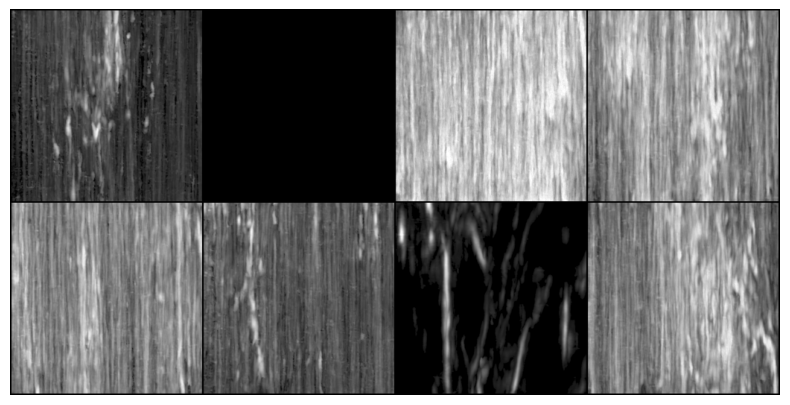

In [6]:
# ===== 4. 进入 eval 模式 =====
model.eval()
diffusion.eval()

# ===== 5. 采样 =====
num_samples = 8   # 想要生成多少张图
batch_size = 8    # 一次全生成，也可以改成更小

with torch.no_grad():
    samples = diffusion.sample(batch_size=batch_size)   # [B, 1, H, W]

print("raw samples shape:", samples.shape)

# ===== 6. 把 [-1,1] 映射回 [0,1]，方便显示 =====
samples = (samples + 1) / 2.0
samples = samples.clamp(0.0, 1.0)

# ===== 7. 拼成 grid（每行 4 张，可以自己改） =====
grid = vutils.make_grid(
    samples, 
    nrow=4,           # 每行几张
    padding=2
)   # 形状 [C, H, W]

grid_np = grid.cpu().numpy()

plt.figure(figsize=(8, 8))

# 如果是单通道（1,C,H,W），用灰度显示
if grid_np.shape[0] == 1:
    plt.imshow(grid_np[0], cmap="gray")
else:
    # 多通道就转成 [H,W,C]
    plt.imshow(np.transpose(grid_np, (1, 2, 0)))

plt.axis("off")
plt.tight_layout()
plt.show()
